# Comparison of motif importance scores from mutagenic series to observed effects
Inputs:
* `best_model.pth.tar`: The final regression model.
* `activity_summary_stats_and_metadata.txt`
* `eLifeMotifs.meme`

Outputs:
* `mutagenicSeriesRorbImportancePredObsWithEnergy.svg`: Observed effect of mutating individual RORB motifs in the mutagenic series vs. the predicted change in motif importance, colored by the relative motif affinity.
* `mutagenicSeriesNonCrxMutants.svg`: Observed effect of mutating individual motifs in WT mutagenic series sequences vs. the predicted change in motif importance.

In [1]:
import os
import sys
import re

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm
import matplotlib.colors as mcolors

from src.mpra_tools import deeplift_utils, fasta_utils, loaders, modeling, predicted_occupancy, plot_utils
from src.selene_files.enhancer_resnet_regression import EnhancerResnet

plot_utils.set_manuscript_params()

data_dir = "Data"
figures_dir = "Figures"

/ref/bclab/software/ryan/.conda/envs/active-learning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load CNN and necessary tables.

In [2]:
L = 164
model = loaders.load_cnn(
    os.path.join("ModelFitting", "CNN_Reg", "best_model", "best_model.pth.tar"),
    model=EnhancerResnet(L),
    eval_mode=True,
)

activity_df = loaders.load_data(
    os.path.join(data_dir, "activity_summary_stats_and_metadata.txt")
)
# Only need the mutagenic series
activity_df = activity_df[activity_df["test_set"]]
activity_df = activity_df[["label", "sequence", "expression_log2", "immediate_precursor", "activity_bin"]]

ewms = predicted_occupancy.read_pwm_to_ewm(
    os.path.join(data_dir, "Downloaded", "eLifeMotifs.meme")
).rename(lambda x: x.split("_")[0])
mu = 9

/ref/bclab/software/ryan/.conda/envs/active-learning/lib/python3.9/site-packages/torch/nn/modules/lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Get saliency maps. Note that instead of the 4 x 164 map, here we just want the 164bp track.

In [3]:
activity_df["saliency_map"] = activity_df["sequence"].apply(deeplift_utils.actual_saliency_track, args=(model,))

Extract designed mutants from each sequence.

In [4]:
strand_decoder = {
    "F": "+",
    "R": "-"
}

# <one-based starting position>d<motif ID>-<strand>
def decode_mutation(encoding):
    splitter = encoding.split("d")
    # Make it zero-based indexing
    start = int(splitter[0]) - 1
    splitter = splitter[1].split("-")
    motif = splitter[0]
    strand = strand_decoder[splitter[1]]
    return (start, motif, strand)

def extract_designed_mutants(key):
    splitter = key.split("HAND_")
    if len(splitter) == 1:
        return []
    
    splitter = splitter[1].split(",")
    tags = [i for i in splitter]
    # tags = [decode_mutation(i) for i in splitter]
    # Make sure motif info is sorted in positional order
    # tags = sorted(tags, key = lambda x: x[0])
    return tags

activity_df["motif_tags"] = activity_df["label"].apply(extract_designed_mutants)

Subset to all designed mutants (i.e. non-WT) and enumerate all possible parental sequences by removing one motif from the list of tags at a time. Keep track of the held-out motif at the same time so we know what the designed perturbation was. Store the result as a list of 2-tuples, where the first value is the list of (n-1) motif tags and the second value is the tag of the held-out motif. Then, [explode](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html) on that list so that each (parent, designed mutant) pair becomes its own row. Finally, separate out the parent link from the designed mutant and recode the name of the parent based on the tags.

In [5]:
def leave_one_out(tags):
    result = []
    for i in range(len(tags)):
        before = tags[:i]
        current = tags[i]
        after = tags[i+1:]
        
        if len(before) == 0:
            combined = after
        elif len(after) == 0:
            combined = before
        else:
            combined = before + after
        
        result.append((
            combined,
            current
        ))
    
    return result

def recode_parent(row):
    base_name = row["immediate_precursor"]
    parent_tags = row["parent"]
    
    if len(parent_tags) == 0:
        return base_name
    else:
        return base_name + ";HAND_" + ",".join(parent_tags)

mutant_df = activity_df[activity_df["motif_tags"].apply(len) > 0].copy()
mutant_df["parent_links"] = mutant_df["motif_tags"].apply(leave_one_out)
mutant_df = mutant_df.explode("parent_links").reset_index()

# Separate the parent link from the designed mutant
mutant_df["parent"] = mutant_df["parent_links"].apply(lambda x: x[0])
mutant_df["designed_mutant"] = mutant_df["parent_links"].apply(lambda x: x[1])
mutant_df = mutant_df.drop(columns="parent_links")

# Recode the parent
mutant_df["parent"] = mutant_df.apply(recode_parent, axis=1)

Now we have a list of all designed mutants and each of their possible precursors ("parents"). Merge this list with the original data to associate the paired measurements.

In [6]:
linked_df = mutant_df.merge(
    activity_df.reset_index(), # Keep the unique ID
    how="left",
    left_on="parent",
    right_on="label",
    suffixes=["_child", "_parent"]
)
# Don't need the `parent` column anymore, redundant with the `label_parent` column
linked_df = linked_df.drop(columns="parent")

# There are some cases where there is no parent -- this is because there
# are two overlapping motifs and the scramble of one also kills the other
no_parent_mask = linked_df["expression_log2_parent"].isna()
print(f"There are {no_parent_mask.sum()} invalid links out of {len(no_parent_mask)} total.")
linked_df = linked_df[~no_parent_mask]

# Decode the motif info
linked_df["designed_mutant"] = linked_df["designed_mutant"].apply(decode_mutation)
linked_df["motif_id"] = linked_df["designed_mutant"].apply(lambda x: x[1])
linked_df["motif_strand"] = linked_df["designed_mutant"].apply(lambda x: x[2])
linked_df["motif_start"] = linked_df["designed_mutant"].apply(lambda x: x[0])
linked_df["motif_stop"] = linked_df.apply(
    lambda x: x["motif_start"] + len(ewms[x["motif_id"]]),
    axis=1
)

# Sanity check
assert all(
    linked_df["immediate_precursor_child"] ==\
    linked_df["immediate_precursor_parent"].fillna(linked_df["label_parent"])
)

# Spot check to make sure I did it right
linked_df[["label_child", "label_parent"]].head(10).values

There are 45 invalid links out of 1960 total.


array([['chr1-135793436-135793600_CPPE_WT;HAND_137dNRL-R',
        'chr1-135793436-135793600_CPPE_WT'],
       ['chr1-171232848-171233012_CPPE_WT;HAND_79dCRX-F',
        'chr1-171232848-171233012_CPPE_WT'],
       ['chr1-191821242-191821406_CPPP_WT;HAND_79dCRX-F',
        'chr1-191821242-191821406_CPPP_WT'],
       ['chr10-118592761-118592925_CPPE_WT;HAND_108dNRL-R,125dNRL-F',
        'chr10-118592761-118592925_CPPE_WT;HAND_125dNRL-F'],
       ['chr10-118592761-118592925_CPPE_WT;HAND_108dNRL-R,125dNRL-F',
        'chr10-118592761-118592925_CPPE_WT;HAND_108dNRL-R'],
       ['chr10-118592761-118592925_CPPE_WT;HAND_108dNRL-R,125dNRL-F,149dCRX-R,152dRORB-F',
        'chr10-118592761-118592925_CPPE_WT;HAND_125dNRL-F,149dCRX-R,152dRORB-F'],
       ['chr10-118592761-118592925_CPPE_WT;HAND_108dNRL-R,125dNRL-F,149dCRX-R,152dRORB-F',
        'chr10-118592761-118592925_CPPE_WT;HAND_108dNRL-R,149dCRX-R,152dRORB-F'],
       ['chr10-118592761-118592925_CPPE_WT;HAND_108dNRL-R,125dNRL-F,149dCRX-R,152d

Ok, now that the paired info is linked up, calculate the observed change in activity and also the predicted change in motif importance.

In [7]:
def get_motif(row, seq_key):
    seq = row[seq_key]
    motif = seq[row["motif_start"]:row["motif_stop"]]
    if row["motif_strand"] == "-":
        motif = fasta_utils.rev_comp(motif)
    return motif

linked_df["obs_wt_vs_mut"] = linked_df["expression_log2_parent"] - linked_df["expression_log2_child"]

linked_df["motif_parent"] = linked_df.apply(get_motif, axis=1, args=("sequence_parent",))
linked_df["motif_child"] = linked_df.apply(get_motif, axis=1, args=("sequence_child",))

linked_df["importance_parent"] = linked_df.apply(
    lambda x: deeplift_utils.motif_importance(x["saliency_map_parent"], x["motif_start"], x["motif_stop"]),
    axis=1
)
linked_df["importance_child"] = linked_df.apply(
    lambda x: deeplift_utils.motif_importance(x["saliency_map_child"], x["motif_start"], x["motif_stop"]),
    axis=1
)

linked_df["importance_change"] = linked_df["importance_parent"] - linked_df["importance_child"]

Look at the pred vs obs deltas for each motif.

CRX	PCC = 0.13329704601548792	SCC = 0.1625001134613072	n = 1289
GFI1	PCC = 0.2773779151221666	SCC = 0.2376972705837117	n = 102
MAZ	PCC = 0.2867521770611499	SCC = 0.482843137254902	n = 17
NDF1	PCC = 0.5269810296031892	SCC = 0.5298387096774194	n = 31
NRL	PCC = -0.0778947788486564	SCC = -0.10405399843602091	n = 90
RAX	PCC = 0.17272274531752596	SCC = 0.1853941585790148	n = 128
RORB	PCC = 0.6766450317516497	SCC = 0.726751610382051	n = 258


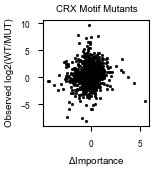

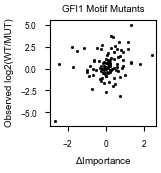

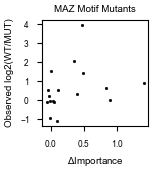

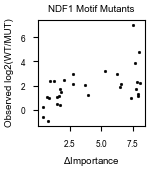

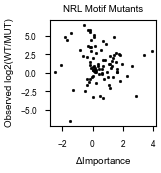

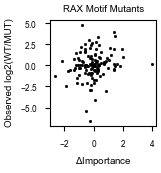

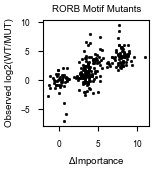

In [8]:
for motif, df in linked_df.groupby("motif_id"):
    fig, ax = plt.subplots(figsize=plot_utils.get_figsize(0.2, aspect=1))
    fig, ax, corrs = plot_utils.scatter_with_corr(
        df["importance_change"],
        df["obs_wt_vs_mut"],
        r"$\Delta$Importance",
        "Observed log2(WT/MUT)",
        # loc="upper left",
        figax=(fig, ax)
    )
    ax.set_title(f"{motif} Motif Mutants")
    print(f"{motif}\tPCC = {corrs[0]}\tSCC = {corrs[1]}\tn = {len(df)}")

Focus on RORB, color by motif instance.

In [9]:
rorb_df = linked_df[linked_df["motif_id"] == "RORB"]
rorb_df["motif_parent"].value_counts()

AAGTAGGTCAC    64
AACTAGGCCAA    62
AAGTAGGTCAG    36
AAGTGGGTCAG    16
ATTAAGGTCAT    13
AATGAGGTTAA     8
ATTGAGGTTAT     8
AACTGGGTTAA     7
GATGAGGTTAT     4
AACTAGGTCAA     4
AAGCAGGTCAG     4
ATTGAGGTCAA     2
AAGGAAATCAT     1
GGAAAATTCAT     1
AGTAAATGCAT     1
ATGAAGAACAT     1
AAATAGAACAT     1
AACTAGGTCTC     1
AAATTGATCAT     1
AACTATTTGAG     1
ATGAAAAGCAT     1
ATGAATTACAT     1
GTTGAGGTTAT     1
AACGTGTATTG     1
AACGTAAAGTC     1
TTAAATGACAT     1
AAAGTTTGCAT     1
ATGAATAGCAT     1
AACTAGGTCCA     1
AACTAGGTCTG     1
AACTGTTAAGT     1
AACGGATGTTT     1
AACAGATGGTA     1
AACTGTGGAGT     1
AACGATTAGTT     1
AGTGAGGTTAT     1
ACTGAGGTTAT     1
TATGAGGTTAT     1
AGATAGATCAT     1
AGAAAATACAT     1
AGATGTAACAT     1
AACTAGGTCTA     1
Name: motif_parent, dtype: int64

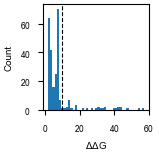

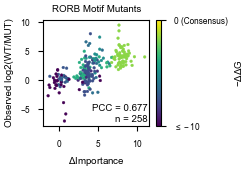

In [10]:
# Color by relative free energy
ddG = rorb_df["motif_parent"].apply(
    # Motif is always on the + strand
    lambda x: predicted_occupancy.energy_landscape(x, ewms["RORB"])[0][0]
)

fig, ax = plt.subplots(figsize=plot_utils.get_figsize(0.2, aspect=1))
ax.hist(ddG, bins="auto")
ax.set_xlabel(r"$\Delta\Delta$G")
ax.set_ylabel("Count")
cutoff = 10
ax.axvline(cutoff, color="k", linestyle="--")

# Normalize the ddG for display
colors = ddG / cutoff
colors[colors > 1] = 1
# For the purposes of display, flip the mapping (negative ddG)
# so that high affinity is shown at the top
colors = 1 - colors
colors = plot_utils.set_color(colors)

fig, ax = plt.subplots(figsize=plot_utils.get_figsize(0.25, aspect=0.8))
fig, ax, corrs = plot_utils.scatter_with_corr(
    rorb_df["importance_change"],
    rorb_df["obs_wt_vs_mut"],
    "$\Delta$Importance",
    "Observed log2(WT/MUT)",
    colors = colors,
    # loc="upper left",
    figax=(fig, ax)
)
ax.text(
    0.98, 0.02,
    f"PCC = {corrs[0]:.3f}\nn = {len(rorb_df)}",
    ha="right",
    va="bottom",
    transform=ax.transAxes
)

ax.set_title(f"RORB Motif Mutants")

norm = mcolors.Normalize(vmin=0, vmax=1)
mapper = matplotlib.cm.ScalarMappable(
    cmap="viridis", norm=norm
).set_array([])

cbar = fig.colorbar(mapper, ax=ax)
cbar.set_label(r"$-\Delta\Delta$G")
cbar.set_ticks([0, 1])
cbar.set_ticklabels([rf"$\leq-${cutoff}", "0 (Consensus)"])

plot_utils.save_fig(fig, os.path.join(figures_dir, "mutagenicSeriesRorbImportancePredObsWithEnergy"))

Lastly, focus on all non-CRX single motif mutations from the WT sequences.

RORB    12
RAX      7
NRL      5
NDF1     3
GFI1     3
MAZ      2
Name: motif_id, dtype: int64

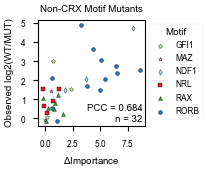

In [11]:
single_mutants = linked_df[
    linked_df["label_parent"].str.contains("WT$") &\
    (linked_df["motif_id"] != "CRX")
]

display(single_mutants["motif_id"].value_counts())

marker_map = {
    "RORB": "o", # circle
    "RAX": "^", # up triangle
    "NRL": "s", # square
    "NDF1": "d", # thin diamond
    "GFI1": "p", # pentagon
    "MAZ": "*", # star
}

color_map = {
    "RORB": "#1f78b4",
    "RAX": "#33a02c",
    "NRL": "#e31a1c",
    "NDF1": "#a6cee3",
    "GFI1": "#b2df8a",
    "MAZ": "#fb9a99",
}


fig, ax = plt.subplots(figsize=plot_utils.get_figsize(0.2, aspect=1))

for motif, df in single_mutants.groupby("motif_id"):
    ax.scatter(
        df["importance_change"],
        df["obs_wt_vs_mut"],
        marker=marker_map[motif],
        color=color_map[motif],
        edgecolors="k",
        s=8,
        label=motif,
    )
    
ax.set_xlabel("$\Delta$Importance")
ax.set_ylabel("Observed log2(WT/MUT)")
ax.legend(
    loc="upper left",
    bbox_to_anchor=(1, 1),
    # frameon=False,
    title="Motif"
)

pcc, _ = stats.pearsonr(
    single_mutants["importance_change"],
    single_mutants["obs_wt_vs_mut"]
)
n = len(single_mutants)
ax.text(
    0.98, 0.02,
    f"PCC = {pcc:.3f}\nn = {n}",
    ha="right",
    va="bottom",
    transform=ax.transAxes
)

ax.set_title("Non-CRX Motif Mutants")
plot_utils.save_fig(fig, os.path.join(figures_dir, "mutagenicSeriesNonCrxMutants"))